<a href="https://colab.research.google.com/github/jkurian49/Neural-Style-Transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code adapted from TensorFlow documentation found at:
https://www.tensorflow.org/tutorials/generative/style_transfer




# Load Images



In [87]:
!git clone https://github.com/jkurian49/Neural-Style-Transfer.git
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

fatal: destination path 'Neural-Style-Transfer' already exists and is not an empty directory.


In [88]:
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

In [89]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [90]:
content_path = 'Neural-Style-Transfer/capitol_riot_images/image_2.jpg'
style_path = 'Neural-Style-Transfer/tapestries/Trojan_War.jpg'

In [91]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [92]:
content_image = load_img(content_path)
style_image = load_img(style_path)

# Fast Style Transfer Using TF-Hub

In [93]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [94]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 440, 64)
  min:  0.0
  max:  595.27966
  mean:  30.671314

block2_conv1
  shape:  (1, 256, 220, 128)
  min:  0.0
  max:  3071.4263
  mean:  161.95857

block3_conv1
  shape:  (1, 128, 110, 256)
  min:  0.0
  max:  5718.0596
  mean:  159.18405

block4_conv1
  shape:  (1, 64, 55, 512)
  min:  0.0
  max:  14106.809
  mean:  581.3657

block5_conv1
  shape:  (1, 32, 27, 512)
  min:  0.0
  max:  1895.6486
  mean:  41.50096



In [95]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [96]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [97]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.06620076
    max:  33460.84
    mean:  712.0348

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  207387.05
    mean:  24859.906

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  583450.7
    mean:  27114.303

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  7470279.0
    mean:  375401.06

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  272084.62
    mean:  3829.123

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  2299.829
    mean:  23.706951


In [98]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

In [99]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [100]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

In [101]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [102]:
total_variation_weight = 30
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
image = tf.Variable(content_image)

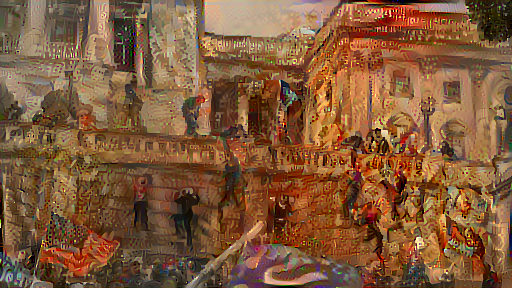

Train step: 2000
Total time: 114.1


In [106]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [104]:
def imshow(image, title=None,save_path=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.axis('off')
  plt.imshow(image)
  if title:
    plt.title(title)
  if save_path:
    plt.savefig(save_path)

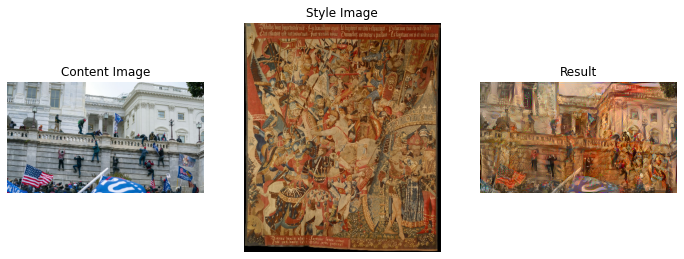

In [105]:
plt.subplot(1, 3, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style_image, 'Style Image')

plt.subplot(1, 3, 3)
imshow(image, 'Result',"/content/Neural-Style-Transfer/results/Capital_2_Trojan_War.jpg")

plt.savefig("/content/Neural-Style-Transfer/results/Capital_2_Trojan_War_Comparison.jpg")

